In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn as sk
import numpy as np

In [19]:
flood_df = pd.read_csv('../data/cleaned_flood_data.csv')
non_flood_df = pd.read_csv('../data/cleaned_non_flood_data.csv')
county_test_df = pd.read_csv('../data/cleaned_county_test_data.csv')

In [20]:
full_df = pd.concat([flood_df, non_flood_df], ignore_index=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18616 entries, 0 to 18615
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   YEAR                          18616 non-null  int64  
 1   MONTH                         18616 non-null  int64  
 2   BEGIN_TIME                    18616 non-null  int64  
 3   BEGIN_LAT                     18616 non-null  float64
 4   BEGIN_LON                     18616 non-null  float64
 5   STATE                         18616 non-null  object 
 6   EVENT_TYPE                    18616 non-null  object 
 7   FLOOD_CAUSE                   8782 non-null   object 
 8   EVENT_NARRATIVE               9215 non-null   object 
 9   temperature_2m_mean           18616 non-null  float64
 10  wind_speed_10m_mean           18616 non-null  float64
 11  cloud_cover_mean              18616 non-null  float64
 12  relative_humidity_2m_mean     18616 non-null  float64
 13  d

In [21]:
full_df = full_df.drop(['precipitation_sum', 'YEAR', 'MONTH', 'STATE', 'FLOOD_CAUSE', 'EVENT_NARRATIVE'], axis=1)
test_df = county_test_df.drop(['precipitation_sum', 'YEAR', 'MONTH'], axis=1)

In [25]:
print(" --- TRAINING DATA --- ")
for column in full_df.columns:
    num_na = full_df[full_df[column].isna()].shape[0]
    print(f"For column {column} there are {num_na} missing values.")

print("\n --- TEST DATA --- ")
for column in test_df.columns:
    num_na = test_df[test_df[column].isna()].shape[0]
    print(f"For column {column} there are {num_na} missing values.")

 --- TRAINING DATA --- 
For column BEGIN_TIME there are 0 missing values.
For column BEGIN_LAT there are 0 missing values.
For column BEGIN_LON there are 0 missing values.
For column EVENT_TYPE there are 0 missing values.
For column temperature_2m_mean there are 0 missing values.
For column wind_speed_10m_mean there are 0 missing values.
For column cloud_cover_mean there are 0 missing values.
For column relative_humidity_2m_mean there are 0 missing values.
For column dew_point_2m_mean there are 0 missing values.
For column rain_sum there are 0 missing values.
For column pressure_msl_mean there are 0 missing values.
For column soil_moisture_0_to_10cm_mean there are 0 missing values.
For column elevation there are 0 missing values.
For column is_primary_rain_season there are 0 missing values.
For column is_secondary_rain_season there are 0 missing values.
For column Flood_Zone_A there are 0 missing values.
For column Flood_Zone_AE there are 0 missing values.
For column Flood_Zone_AH ther

In [27]:
def convert_event_type(row):
    if row == 'Flash Flood':
        row = 'Flood'
    return row

In [28]:
# X = full_df.drop(columns=["EVENT_TYPE"])

# y = full_df['EVENT_TYPE'].apply(convert_event_type)

# le = sk.preprocessing.LabelEncoder()
# y_encoded = le.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y_encoded, test_size=0.2, random_state=42, stratify=y
# )

In [32]:
X_train_all = full_df.drop(columns=["EVENT_TYPE"])
y = full_df['EVENT_TYPE'].apply(convert_event_type)

le = sk.preprocessing.LabelEncoder()
y_train_all = le.fit_transform(y)

missing_cols = set(X_train_all.columns) - set(test_df.columns)
for c in missing_cols:
    test_df[c] = 0

X_inference = test_df[X_train_all.columns]

In [36]:
# ===== Block 21: KNN + PCA + StandardScaler (model testing) =====

from sklearn.experimental import enable_halving_search_cv
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()

pipeline_knn = sk.pipeline.Pipeline(
    steps=[
        ("scaler", scaler),
        ("pca", pca),
        ("classifier", knn),
    ]
)

param_grid_knn = {
    "pca__n_components": list(range(5, 20)),
    "classifier__n_neighbors": list(range(1, 26)),
}
knn_grid = sk.model_selection.HalvingGridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)
scores = sk.model_selection.cross_val_score(
    estimator=knn_grid,
    X=X_train,
    y=y_train,
    cv=5,
    verbose=3
)
print(f"KNN + PCA: average accuracy = {scores.mean():.4f}")

knn_grid.fit(X_train, y_train)
print("Best accuracy (KNN+PCA):", knn_grid.best_score_)
print("Best parameters (KNN+PCA):", knn_grid.best_params_)

[CV] END ................................ score: (test=0.682) total time=   5.3s
[CV] END ................................ score: (test=0.782) total time=   3.2s
[CV] END ................................ score: (test=0.665) total time=   3.5s
[CV] END ................................ score: (test=0.753) total time=   3.3s
[CV] END ................................ score: (test=0.775) total time=   3.4s
KNN + PCA: average accuracy = 0.7313


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.7s finished


Best accuracy (KNN+PCA): 0.7333026560434034
Best parameters (KNN+PCA): {'classifier__n_neighbors': 1, 'pca__n_components': 6}


In [37]:
scaler = sk.preprocessing.StandardScaler()
mlp = sk.neural_network.MLPClassifier(max_iter=5000, random_state=42)

pipeline_mlp = sk.pipeline.Pipeline(
    steps=[
        ("scaler", scaler),
        ("classifier", mlp),
    ]
)

param_grid_mlp = {
    "classifier__hidden_layer_sizes": [(200, 100)],
    "classifier__activation": ["tanh"],
    "classifier__solver": ["adam"],
    "classifier__alpha": [0.05],
    "classifier__learning_rate_init": [0.001],
}

mlp_grid = sk.model_selection.GridSearchCV(
    estimator=pipeline_mlp,
    param_grid=param_grid_mlp,
    cv=5,
    scoring="accuracy",
    verbose=3,
    n_jobs=-1,
)

mlp_grid.fit(X_train, y_train)

mlp_results = pd.DataFrame(mlp_grid.cv_results_)
cols_to_keep = [
    "param_classifier__hidden_layer_sizes",
    "param_classifier__alpha",
    "mean_test_score",
]
print(
    mlp_results[cols_to_keep]
    .sort_values("mean_test_score", ascending=False)
)

print("Best parameters (MLP):", mlp_grid.best_params_)
print("Best CV accuracy (MLP):", mlp_grid.best_score_)

nested_scores = sk.model_selection.cross_val_score(
    estimator=mlp_grid,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="accuracy",
    verbose=3,
    n_jobs=-1
)

final_accuracy = np.mean(nested_scores)
print(f"\nNested CV Mean Accuracy: {final_accuracy:.4f}")
print(f"Individual Outer Fold Scores: {nested_scores}")
print("Best Hyperparameters:", mlp_grid.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
  param_classifier__hidden_layer_sizes  param_classifier__alpha  \
0                           (200, 100)                     0.05   

   mean_test_score  
0         0.797475  
Best parameters (MLP): {'classifier__activation': 'tanh', 'classifier__alpha': 0.05, 'classifier__hidden_layer_sizes': (200, 100), 'classifier__learning_rate_init': 0.001, 'classifier__solver': 'adam'}
Best CV accuracy (MLP): 0.7974752301255419


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min



Nested CV Mean Accuracy: 0.7975
Individual Outer Fold Scores: [0.80060423 0.7932192  0.79482874 0.79919409 0.79952989]
Best Hyperparameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.05, 'classifier__hidden_layer_sizes': (200, 100), 'classifier__learning_rate_init': 0.001, 'classifier__solver': 'adam'}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [42]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(200, 100), 
        activation="tanh", 
        solver="adam", 
        alpha=0.05, 
        learning_rate_init=0.001,
        max_iter=5000, 
        random_state=42
    )
)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1862
           1       0.82      0.82      0.82      1862

    accuracy                           0.82      3724
   macro avg       0.82      0.82      0.82      3724
weighted avg       0.82      0.82      0.82      3724



In [33]:
unique_values, counts = np.unique(y_test, return_counts=True)

print("Unique Values:", unique_values)
print("Counts:", counts)

Unique Values: [0 1]
Counts: [1862 1862]


In [42]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

final_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(200, 100), 
        activation="tanh", 
        solver="adam", 
        alpha=0.05, 
        learning_rate_init=0.001,
        max_iter=5000, 
        random_state=42
    )
)

final_model.fit(X_train_all, y_train_all)

predicted_risk = final_model.predict_proba(X_inference)[:, 0]
print(predicted_risk)

[2.57972778e-01 1.62710982e-03 7.99335364e-01 1.01830006e-02
 9.33426034e-02 9.99897847e-01 2.49798815e-01 9.99995236e-01
 8.30784889e-01 5.12398859e-01 7.88202152e-01 9.17799914e-01
 9.89147149e-01 9.59330484e-02 9.76576236e-01 9.98548873e-01
 1.10289476e-01 6.71456898e-01 5.15205059e-01 9.98297127e-01
 9.90955554e-01 1.60281413e-01 9.90869291e-01 5.38708985e-03
 1.06539436e-01 9.75066857e-01 8.11963396e-01 3.64882261e-01
 5.05395185e-01 9.51618186e-01 1.81835782e-02 5.04129738e-01
 3.82562628e-03 9.76875038e-01 9.99820698e-01 7.93410876e-01
 4.80463844e-02 5.70900014e-04 6.75127594e-03 3.97683346e-03
 9.27584134e-01 8.31492707e-01 2.44222883e-01 1.17907628e-01
 9.97019204e-01 7.09613144e-04 9.92267703e-01 8.62897976e-01
 3.07042186e-03 2.98336993e-02 9.99924839e-01 9.97109937e-01
 9.86909625e-01 6.05583407e-01 3.15009928e-03 4.04958127e-02
 1.93092897e-01 1.07030551e-02 9.57619881e-01 7.62927515e-01
 7.47615147e-02 8.55990916e-01 3.64944658e-01 9.84296527e-01
 4.67762742e-01 9.527881

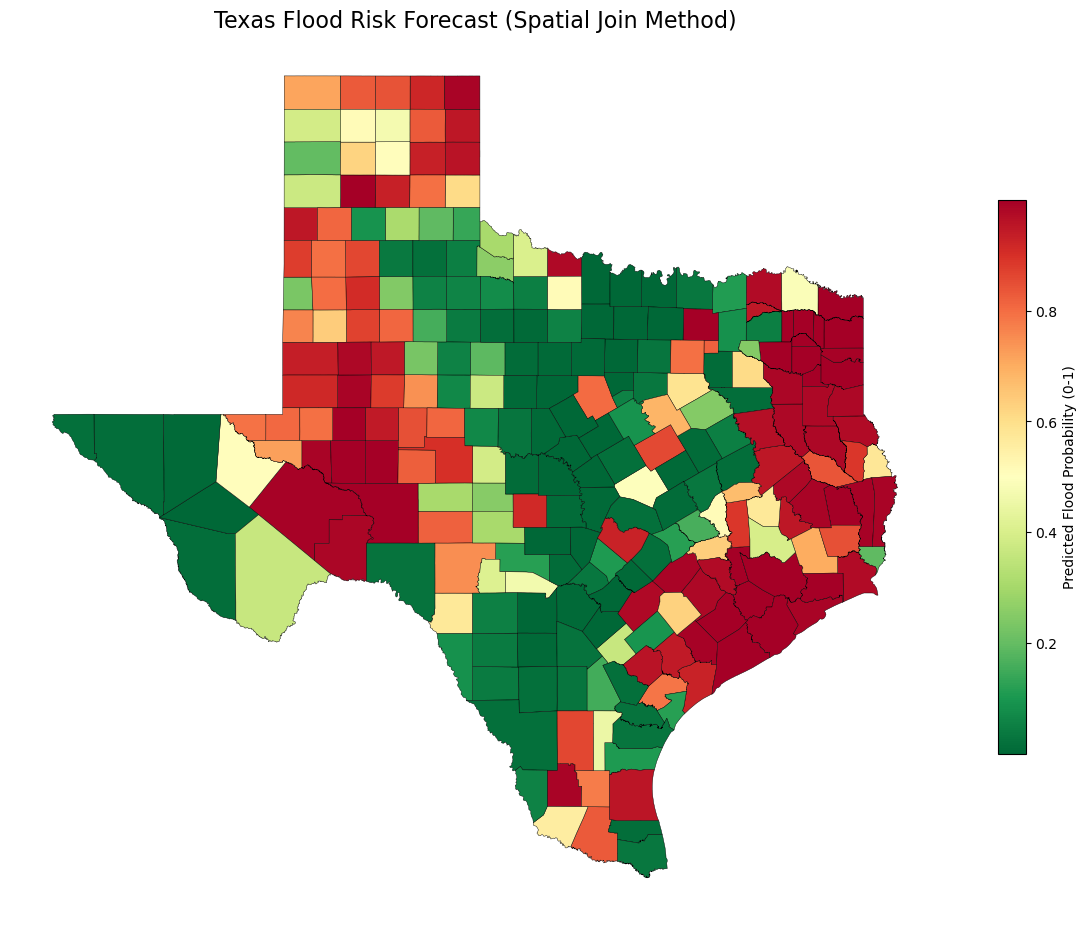

Top Riskiest Counties (Identified via Geometry):
      Risk_Score
437     0.999995
2225    0.999995
674     0.999982
894     0.999925
2972    0.999905


In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

county_test_df['Risk_Score'] = predicted_risk

gdf_points = gpd.GeoDataFrame(
    county_test_df, 
    geometry=gpd.points_from_xy(county_test_df.BEGIN_LON, county_test_df.BEGIN_LAT),
    crs="EPSG:4326"  # GPS Coordinates
)

census_url = "https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip"
gdf_counties = gpd.read_file(census_url)
gdf_tx = gdf_counties[gdf_counties['STATEFP'] == '48'].to_crs("EPSG:4326")

gdf_map = gpd.sjoin(gdf_tx, gdf_points, how="inner", predicate="contains")

fig, ax = plt.subplots(figsize=(15, 12))

gdf_map.plot(column='Risk_Score', 
             ax=ax, 
             legend=True,
             cmap='RdYlGn_r',      # Red=High Risk, Green=Low Risk (Reversed)
             edgecolor='black',
             linewidth=0.3,
             legend_kwds={'label': "Predicted Flood Probability (0-1)", 'shrink': 0.6})

plt.title("Texas Flood Risk Forecast (Spatial Join Method)", fontsize=16)
plt.axis('off')

# Save and Show
plt.savefig("texas_flood_risk_map_spatial.png", dpi=300)
plt.show()

# Optional: See which counties ended up being riskiest (Using the NAME from the Shapefile now!)
print("Top Riskiest Counties (Identified via Geometry):")
print(gdf_map[['Risk_Score']].sort_values(by='Risk_Score', ascending=False).head())

In [38]:
west_texas_county = county_test_df[county_test_df['BEGIN_LON'] < -104]
pd.options.display.max_columns = None
print(west_texas_county)

     YEAR  MONTH  BEGIN_TIME  BEGIN_LAT   BEGIN_LON        NAME  \
30   2025      4           0  31.768623 -106.235223     El Paso   
48   2025      4           0  30.715593 -104.140354  Jeff Davis   
182  2025      4           0  31.447098 -104.517742   Culberson   
184  2025      4           0  31.456137 -105.386943    Hudspeth   
241  2025      4           0  29.999778 -104.240555    Presidio   

     temperature_2m_mean  wind_speed_10m_mean  cloud_cover_mean  \
30             22.283770            23.097136          5.712891   
48             19.234630            21.780243          4.796669   
182            21.524918            24.347723          0.000000   
184            21.183197            28.643736         12.509819   
241            21.744637            23.619290          2.384609   

     relative_humidity_2m_mean  dew_point_2m_mean  precipitation_sum  \
30                   15.081154          -6.136408                0.0   
48                   20.380562          -4.037561 

In [40]:
print("Classes in order [index 0, index 1]:", final_model.classes_)

# 2. Check your training data to see what '1' represents
# (Assuming y_train_all is a pandas Series)
print("\nValue counts in y_train_all:")
print(pd.Series(y_train_all).value_counts())

Classes in order [index 0, index 1]: [0 1]

Value counts in y_train_all:
0    9308
1    9308
Name: count, dtype: int64


In [41]:
print("Class 0 is:", le.classes_[0])
print("Class 1 is:", le.classes_[1])

Class 0 is: Flood
Class 1 is: Normal
